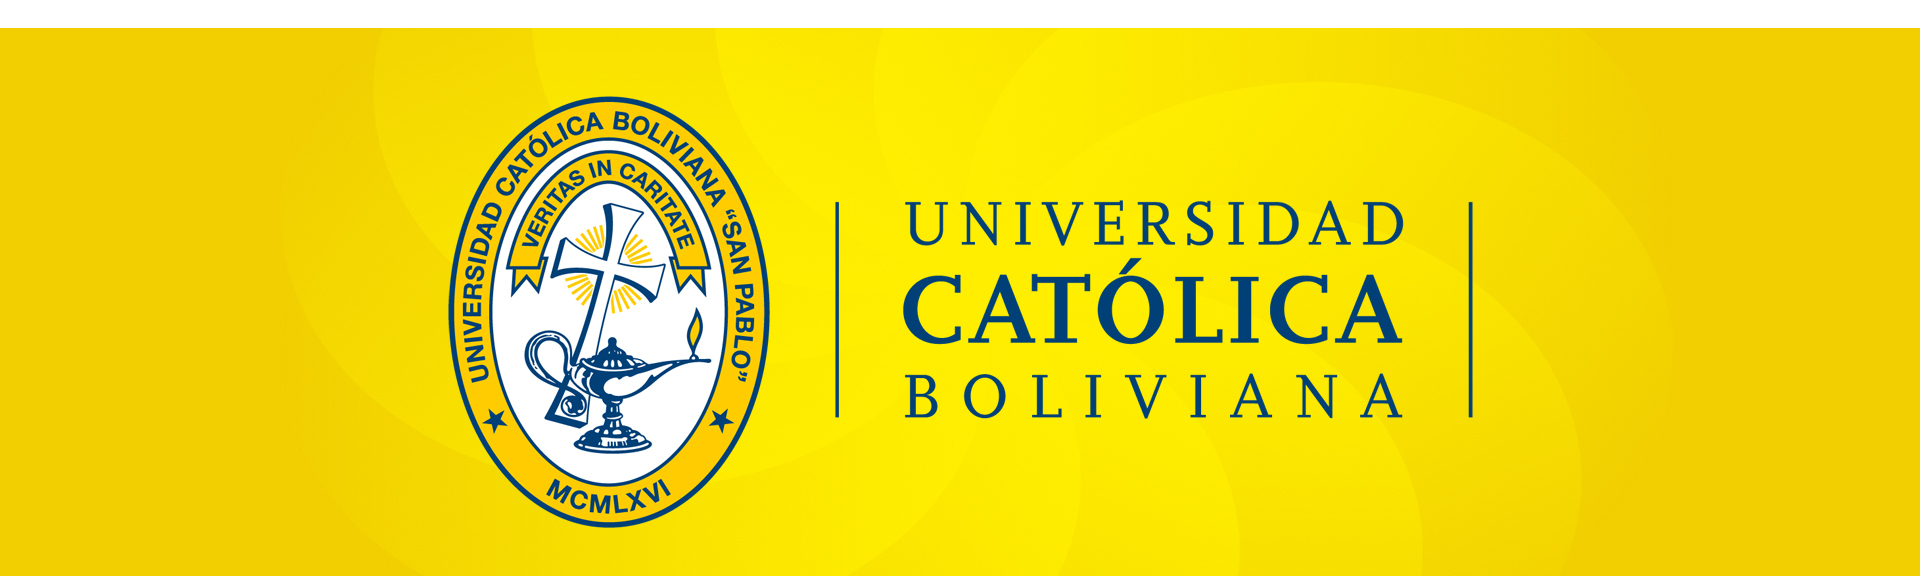

## **GRUPO: CLUSTERING**



# Clasificacion Automatica de Tickets con NLP

### Integrantes
* Elizabeth Alcon
* Romel Cruz
* Lucy Alcon

## Descripcion del Problema

Debe crear un modelo que pueda clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Al hacerlo, puede segregar estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Realizará el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, debe aplicar NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, podrá asignar cada ticket a su respectivo departamento/categoría. Luego puede usar estos datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, puede clasificar cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

## Flujo de Trajajo a Realizar:

Debe realizar las siguientes ocho tareas principales para completar la tarea:

1. Data Loading

2. Text preprocessing

3. Exploratory Data Analysis (EDA)

4. Feature Extraction

5. Topic modeling

6. Model building using Supervised Learning

7. Model training and evaluation

8. Model inference

## Setup e Importacion de Librerias

In [1]:
## SpaCy and en_core_web_sm installation
!pip install spacy

##run the following command in the console
#python -m spacy download en_core_web_sm

In [2]:
# !pip install unidecode --quiet
# !pip install -q spacy==3.7.2 unidecode
# !python -m spacy download es_core_news_md

## Importing the necessary libraries

In [3]:
import json
import numpy as np
import pandas as pd
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import string
import re

In [4]:
# Uninstall potentially conflicting packages
!pip uninstall spacy torch -y

Found existing installation: spacy 3.8.7
Uninstalling spacy-3.8.7:
  Successfully uninstalled spacy-3.8.7
Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126


In [5]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Loading the data

Los datos están en formato JSON y necesitamos convertirlos a un dataframe.

# Opening JSON file


In [6]:
from google.colab import files
uploaded = files.upload()

Saving complaints.json to complaints.json


In [7]:
# Opening JSON file
f = '/content/complaints.json' # Write the path to your data file and load it # returns JSON object as # a dictionary
df=pd.read_json(f)

In [9]:
# Leer el archivo JSON
with open(f, 'r', encoding='utf-8') as file:
    data = json.load(file)
# Normalizar los datos (convierte estructuras anidadas en columnas planas)
df = pd.json_normalize(data)

## Data preparation

In [11]:
#  Inspeccionar el DataFrame
print("Primeras filas del DataFrame:")
print(df.head())

Primeras filas del DataFrame:
                _index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state  ... _source.company_response  \
0  2

In [12]:
print("\n Información general del DataFrame:")
print(df.info())


 Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product  

In [14]:
print("Dimensiones del DataFrame:")
print(f"Filas: {df.shape[0]}, Columnas: {df.shape[1]}")

Dimensiones del DataFrame:
Filas: 78313, Columnas: 22


In [16]:
print("Nombres de las columnas:")
print(df.columns.tolist())

Nombres de las columnas:
['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [17]:
print("Valores nulos por columna:")
print(df.isnull().sum())

Valores nulos por columna:
_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64


In [18]:
print("Estadísticas descriptivas de columnas numéricas:")
print(df.describe(include='all'))

Estadísticas descriptivas de columnas numéricas:
                     _index      _type      _id   _score    _source.tags  \
count                 78313      78313    78313  78313.0           10900   
unique                    1          1    78313      NaN               3   
top     complaint-public-v2  complaint  2001189      NaN  Older American   
freq                  78313      78313        1      NaN            6103   
mean                    NaN        NaN      NaN      0.0             NaN   
std                     NaN        NaN      NaN      0.0             NaN   
min                     NaN        NaN      NaN      0.0             NaN   
25%                     NaN        NaN      NaN      0.0             NaN   
50%                     NaN        NaN      NaN      0.0             NaN   
75%                     NaN        NaN      NaN      0.0             NaN   
max                     NaN        NaN      NaN      0.0             NaN   

       _source.zip_code _source.compla

In [19]:
#print the column names
print("Columnas del DataFrame:")
for col in df.columns:
    print(col)

Columnas del DataFrame:
_index
_type
_id
_score
_source.tags
_source.zip_code
_source.complaint_id
_source.issue
_source.date_received
_source.state
_source.consumer_disputed
_source.product
_source.company_response
_source.company
_source.submitted_via
_source.date_sent_to_company
_source.company_public_response
_source.sub_product
_source.timely
_source.complaint_what_happened
_source.sub_issue
_source.consumer_consent_provided


In [21]:
#Assign new column names
df.columns = [
    "index",
    "type",
    "id",
    "score",
    "tags",
    "zip_code",
    "complaint_id",
    "issue",
    "date_received",
    "state",
    "consumer_disputed",
    "product",
    "company_response",
    "company",
    "submitted_via",
    "date_sent_to_company",
    "company_public_response",
    "sub_product",
    "timely",
    "complaint_what_happened",
    "sub_issue",
    "consumer_consent_provided"
]

# Confirmar el cambio
print("Nuevos nombres de columnas:")
print(df.columns.tolist())

Nuevos nombres de columnas:
['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']


In [22]:
#Assign nan in place of blanks in the complaints column
# Reemplazar los valores vacíos o espacios en blanco por NaN
df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
# Confirmar cuántos valores quedaron como NaN
print("Cantidad de valores NaN en la columna 'complaint_what_happened':")
print(df['complaint_what_happened'].isna().sum())
# Opcional: mostrar algunas filas con NaN para verificar
print("\nEjemplo de filas con NaN:")
print(df[df['complaint_what_happened'].isna()].head())

Cantidad de valores NaN en la columna 'complaint_what_happened':
57241

Ejemplo de filas con NaN:
                 index       type       id  score            tags zip_code  \
0  complaint-public-v2  complaint  3211475    0.0            None    90301   
3  complaint-public-v2  complaint  2673060    0.0            None    48066   
4  complaint-public-v2  complaint  3203545    0.0            None    10473   
5  complaint-public-v2  complaint  3275312    0.0  Older American    48227   
6  complaint-public-v2  complaint  3238804    0.0            None    76262   

  complaint_id                              issue              date_received  \
0      3211475  Attempts to collect debt not owed  2019-04-13T12:00:00-05:00   
3      2673060     Trouble during payment process  2017-09-13T12:00:00-05:00   
4      3203545                   Fees or interest  2019-04-05T12:00:00-05:00   
5      3275312                Managing an account  2019-06-13T12:00:00-05:00   
6      3238804                Man

In [23]:
#Remove all rows where complaints column is nan
# Eliminar filas donde 'complaint_what_happened' es NaN
df.dropna(subset=['complaint_what_happened'], inplace=True)
# Confirmar tamaño del DataFrame después
print("Filas restantes tras eliminar vacíos:", df.shape[0])

Filas restantes tras eliminar vacíos: 21072


## Prepare the text for topic modeling

Una vez que haya eliminado todas las quejas en blanco, debe:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers

Una vez que haya realizado estas operaciones de limpieza, debe realizar lo siguiente:

* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [26]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    if isinstance(text, str):
        # Convertir a minúsculas
        text = text.lower()
        # Eliminar correos electrónicos
        text = re.sub(r'\S+@\S+', '', text)
        # Eliminar URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        # Eliminar números
        text = re.sub(r'\d+', '', text)
        # Eliminar signos de puntuación
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Eliminar caracteres no alfabéticos y espacios múltiples
        text = re.sub(r'[^a-z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ''
# Aplicar la función a la columna de quejas
df['clean_complaint'] = df['complaint_what_happened'].apply(clean_text)
# Mostrar algunas filas para verificar el resultado
print(df[['complaint_what_happened', 'clean_complaint']].head(10))


                              complaint_what_happened  \
1   Good morning my name is XXXX XXXX and I apprec...   
2   I upgraded my XXXX XXXX card in XX/XX/2018 and...   
10  Chase Card was reported on XX/XX/2019. However...   
11  On XX/XX/2018, while trying to book a XXXX  XX...   
14  my grand son give me check for {$1600.00} i de...   
15                      Can you please remove inquiry   
17  With out notice J.P. Morgan Chase restricted m...   
20  During the summer months, I experience a decli...   
21  On XXXX XX/XX/2019, I made a {$300.00} payment...   
23  I have a Chase credit card which is incorrectl...   

                                      clean_complaint  
1   good morning my name is xxxx xxxx and i apprec...  
2   i upgraded my xxxx xxxx card in xxxx and was t...  
10  chase card was reported on xxxx however fraudu...  
11  on xxxx while trying to book a xxxx xxxx ticke...  
14  my grand son give me check for i deposit it in...  
15                      can you plea

In [29]:
# Write your function to Lemmatize the texts
# Descargar recursos necesarios (solo una vez)
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
# Crear el lematizador y lista de stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# Función para limpiar y lematizar texto
def clean_and_lemmatize(text):
    if not isinstance(text, str):
        return ""
    # Convertir a minúsculas
    text = text.lower()
    # Quitar números y signos de puntuación
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    text = re.sub(r'\d+', '', text)
    # Tokenizar por palabras
    words = text.split()
    # Quitar stopwords y lematizar
    lemmas = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(lemmas)
# Aplicar al DataFrame
df['clean_complaint'] = df['complaint_what_happened'].apply(clean_and_lemmatize)
# Verificar resultados
print("Ejemplo de texto lematizado:")
print(df[['complaint_what_happened', 'clean_complaint']].head(3))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Ejemplo de texto lematizado:
                              complaint_what_happened  \
1   Good morning my name is XXXX XXXX and I apprec...   
2   I upgraded my XXXX XXXX card in XX/XX/2018 and...   
10  Chase Card was reported on XX/XX/2019. However...   

                                      clean_complaint  
1   good morning name xxxx xxxx appreciate could h...  
2   upgraded xxxx xxxx card xx xx told agent upgra...  
10  chase card reported xx xx however fraudulent a...  


In [30]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
# Crear un nuevo DataFrame solo con las columnas necesarias
df_clean = df[['complaint_what_happened', 'clean_complaint']].copy()
# Verificar las primeras filas
print("DataFrame 'df_clean' creado correctamente.")
print(df_clean.head())
# Verificar tamaño y valores faltantes
print("\nDimensiones del nuevo DataFrame:", df_clean.shape)
print("\nValores faltantes por columna:")
print(df_clean.isna().sum())


DataFrame 'df_clean' creado correctamente.
                              complaint_what_happened  \
1   Good morning my name is XXXX XXXX and I apprec...   
2   I upgraded my XXXX XXXX card in XX/XX/2018 and...   
10  Chase Card was reported on XX/XX/2019. However...   
11  On XX/XX/2018, while trying to book a XXXX  XX...   
14  my grand son give me check for {$1600.00} i de...   

                                      clean_complaint  
1   good morning name xxxx xxxx appreciate could h...  
2   upgraded xxxx xxxx card xx xx told agent upgra...  
10  chase card reported xx xx however fraudulent a...  
11  xx xx trying book xxxx xxxx ticket came across...  
14  grand son give check deposit chase account fun...  

Dimensiones del nuevo DataFrame: (21072, 2)

Valores faltantes por columna:
complaint_what_happened    0
clean_complaint            0
dtype: int64


In [34]:

from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [32]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [35]:
# Define the function to extract nouns (NN) and lemmatize them
def pos_tag_extraction(text):
    """
    This function performs POS tagging on the input text,
    keeps only the words tagged as 'NN' (nouns),
    and returns the lemmatized version of those nouns.
    """
    lemmatizer = WordNetLemmatizer()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Get POS tags
    tagged_words = pos_tag(tokens)

    # Keep only words with POS tag 'NN' (nouns)
    nouns = [word for word, tag in tagged_words if tag == "NN"]

    # Lemmatize the nouns
    lemmatized_nouns = [lemmatizer.lemmatize(word) for word in nouns]

    # Join them back into a single string
    return " ".join(lemmatized_nouns)

# Apply the function to the cleaned complaints column
df_clean["complaint_POS_removed"] = df_clean["clean_complaint"].apply(pos_tag_extraction)

# Display the first few rows to check the result
df_clean[["clean_complaint", "complaint_POS_removed"]].head()

,clean_complaint,complaint_POS_removed
1,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...
2,upgraded xxxx xxxx card xx xx told agent upgra...,xxxx card agent date agent information order u...
10,chase card reported xx xx however fraudulent a...,chase card application identity consent servic...
11,xx xx trying book xxxx xxxx ticket came across...,book ticket offer ticket card information offe...
14,grand son give check deposit chase account fun...,son check deposit chase account fund chase ban...


In [36]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Exploratory data analysis to get familiar with the data.

Escriba el código en esta tarea para realizar lo siguiente:

* Visualiza los datos según la longitud del carácteres 'Complaint'
* Usando una nube de palabras, encuentre las top 40 palabras más frecuentes de todos los artículos después de procesar el texto
* Encuentre los mejores unigramas, bigramas y trigramas por frecuencia entre todas las quejas después de procesar el texto. '

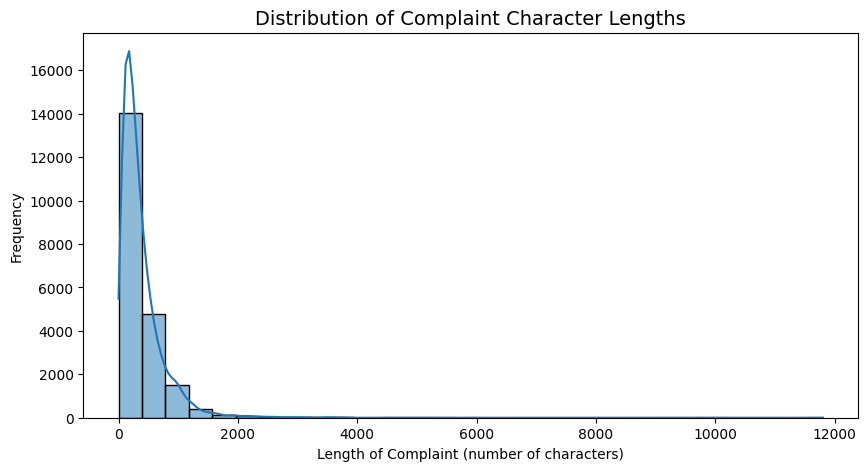

In [37]:

# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaint_POS_removed'].apply(lambda x: len(str(x)))

plt.figure(figsize=(10,5))
sns.histplot(df_clean['complaint_length'], bins=30, kde=True)
plt.title("Distribution of Complaint Character Lengths", fontsize=14)
plt.xlabel("Length of Complaint (number of characters)")
plt.ylabel("Frequency")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

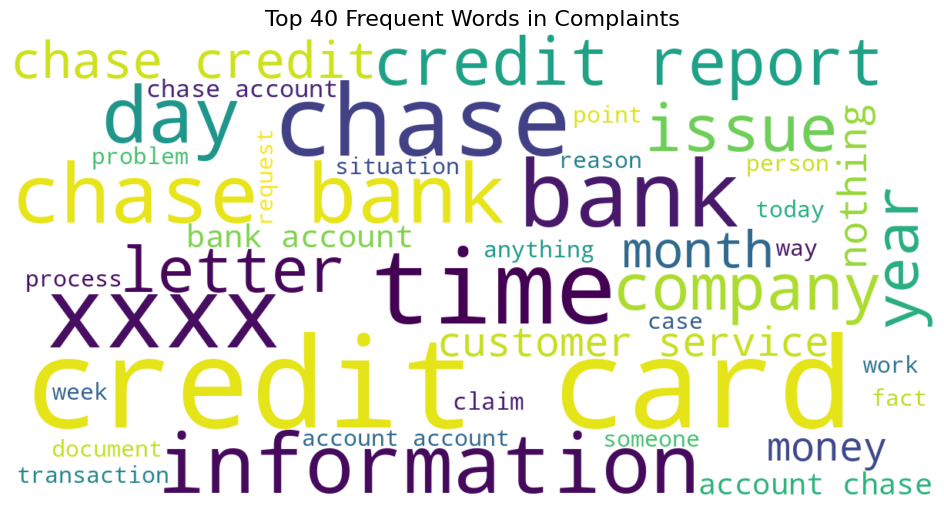

In [38]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = ' '.join(df_clean['complaint_POS_removed'])

wordcloud = WordCloud(width=1200, height=600,
                      max_words=40,
                      background_color='white',
                      colormap='viridis').generate(all_words)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 40 Frequent Words in Complaints", fontsize=16)
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [40]:

# Function to get the top n n-grams
def get_top_n_ngrams(corpus, n=None, ngram=1):
    vec = CountVectorizer(stop_words='english', ngram_range=(ngram, ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [41]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
# Get top 30 unigrams
top_30_unigrams = get_top_n_ngrams(df_clean['complaint_POS_removed'].dropna(), n=30, ngram=1)
print("Top 30 Unigrams:")
for word, freq in top_30_unigrams:
    print(f"{word}: {freq}")

Top 30 Unigrams:
chase: 53575
account: 45451
credit: 33242
bank: 28362
card: 27143
payment: 21369
xxxx: 16690
time: 16318
day: 13330
charge: 13131
money: 12006
loan: 11062
letter: 9720
information: 9690
check: 9007
transaction: 8694
number: 8652
month: 8624
year: 8475
fee: 8378
mortgage: 8229
customer: 8210
report: 8180
service: 7733
balance: 7708
company: 7667
phone: 7619
claim: 7530
fraud: 7205
fund: 6978


In [42]:
# Function to get the top n n-grams
def get_top_n_ngrams(corpus, n=None, ngram=1):
    vec = CountVectorizer(stop_words='english', ngram_range=(ngram, ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [43]:
# Replace 'xxxx' with an empty string in the 'Complaint_clean' column
df_clean['clean_complaint'] = df_clean['clean_complaint'].str.replace('xxxx', '', regex=False)
# Optional: Check if any 'xxxx' remain
remaining_xxxx = df_clean['clean_complaint'].str.contains('xxxx').sum()
print(f"Number of rows still containing 'xxxx': {remaining_xxxx}")
# Display a few cleaned examples
df_clean[['clean_complaint']].head()

Number of rows still containing 'xxxx': 0


,clean_complaint
1,good morning name appreciate could help put ...
2,upgraded card xx xx told agent upgrade anniv...
10,chase card reported xx xx however fraudulent a...
11,xx xx trying book ticket came across offer a...
14,grand son give check deposit chase account fun...


## Feature Extraction
Convierta los textos sin procesar en una matriz de características TF-IDF

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [44]:
# Write your code here to initialise the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,       # ignore terms that appear in more than 95% of documents
    min_df=2,          # ignore terms that appear in less than 2 documents
    stop_words='english',  # remove common English stopwords
    ngram_range=(1,2)      # include unigrams and bigrams to capture more context
)
# Fit and transform the processed text data
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['complaint_POS_removed'])
# Check the shape of the resulting matrix
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
# Display feature names (optional, only first 20 for readability)
print("Sample of TF-IDF feature names:\n", tfidf_vectorizer.get_feature_names_out()[:20])


TF-IDF matrix shape: (21072, 97997)
Sample of TF-IDF feature names:
 ['aa' 'aarp' 'aarp account' 'aarp card' 'aarp chase' 'aarp credit' 'ab'
 'abandonment' 'abatement' 'abbreviation' 'abd' 'abet' 'abet activity'
 'abhorrent' 'abide' 'abide agreement' 'ability' 'ability access'
 'ability account' 'ability bank']


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [45]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
# Transform the text data into a document-term matrix
dtm = tfidf_vectorizer.fit_transform(df_clean['complaint_POS_removed'])
# Convert the sparse matrix to a dense DataFrame for better readability (optional)
dtm_df = pd.DataFrame(dtm.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En esta tarea tienes que realizar lo siguiente:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

* Encuentra el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas (Complaints)
* Corrija las etiquetas si es necesario
* Mapear el grupo de nombres de topicos/clusters

In [46]:
# 1. Feature Extraction using TF-IDF
print("🔧 Extrayendo características con TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,           # Ignorar términos que aparecen en más del 95% de documentos
    min_df=2,              # Ignorar términos que aparecen en menos de 2 documentos
    max_features=1000,     # Máximo número de features
    stop_words='english',  # Remover stop words en inglés
    ngram_range=(1, 2)     # Considerar unigramas y bigramas
)

🔧 Extrayendo características con TF-IDF...


In [48]:
# Aplicar TF-IDF a los textos procesados
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['complaint_POS_removed'])
print(f" Matriz TF-IDF creada: {tfidf_matrix.shape}")
# 2. Find the best number of clusters using Coherence Score
print("Buscando el mejor número de temas...")
def calculate_coherence_score(nmf_model, tfidf_matrix, feature_names, top_n=10):
    """Calcula el coherence score para evaluar la calidad de los temas"""
    coherence_scores = []
    # Obtener los temas (W matrix)
    W = nmf_model.transform(tfidf_matrix)
    H = nmf_model.components_
    for topic_idx, topic in enumerate(H):
        # Obtener las top_n palabras más importantes para este tema
        top_words = [feature_names[i] for i in topic.argsort()[:-top_n-1:-1]]
        # Calcular coherence score simple (basado en co-ocurrencia)
        score = 0
        for i in range(len(top_words)):
            for j in range(i+1, len(top_words)):
                # Co-ocurrencia simple (podría mejorarse con PMI)
                if top_words[i] in tfidf_vectorizer.vocabulary_ and top_words[j] in tfidf_vectorizer.vocabulary_:
                    score += 1
        coherence_scores.append(score)
    return np.mean(coherence_scores)

 Matriz TF-IDF creada: (21072, 1000)
Buscando el mejor número de temas...


   Probando con 3 temas...
      Coherence Score: 45.0
   Probando con 4 temas...
      Coherence Score: 45.0
   Probando con 5 temas...
      Coherence Score: 45.0
   Probando con 6 temas...
      Coherence Score: 45.0
   Probando con 7 temas...
      Coherence Score: 45.0
Mejor número de temas encontrado: 3 con Coherence Score: 45.0


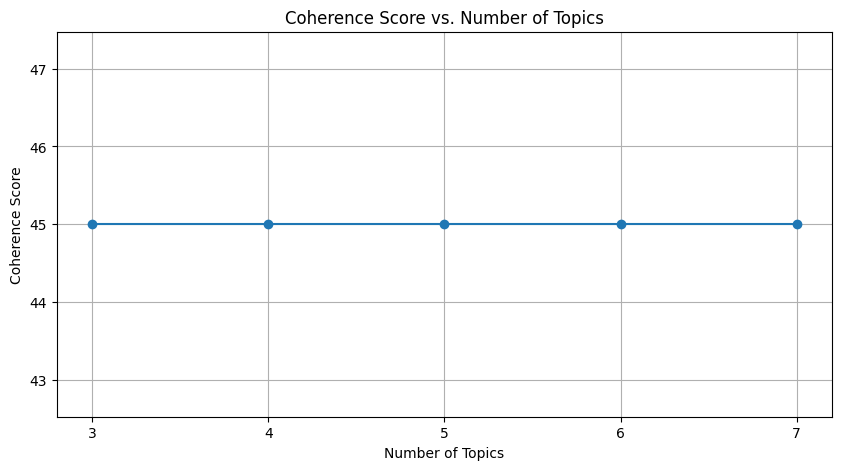

In [49]:
# Probar diferentes números de temas
topic_range = range(3, 8)  # Probamos de 3 a 7 temas
best_score = -1
best_n_topics = 3
coherence_scores = []
feature_names = tfidf_vectorizer.get_feature_names_out()
for n_topics in topic_range:
    print(f"   Probando con {n_topics} temas...")
    # Aplicar NMF
    nmf = NMF(
        n_components=n_topics,
        random_state=42,
        max_iter=1000
    )
    W = nmf.fit_transform(tfidf_matrix)
    H = nmf.components_
    # Calcular coherence score (usando la función definida previamente)
    score = calculate_coherence_score(nmf, tfidf_matrix, feature_names)
    coherence_scores.append(score)
    print(f"      Coherence Score: {score}")
    # Actualizar el mejor modelo si el score es mejor
    if score > best_score:
        best_score = score
        best_n_topics = n_topics
print(f"Mejor número de temas encontrado: {best_n_topics} con Coherence Score: {best_score}")
# Opcional: Visualizar los scores
plt.figure(figsize=(10, 5))
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(topic_range)
plt.grid(True)
plt.show()

In [50]:
# Initialize and train the NMF model with the best number of topics
nmf_model = NMF(n_components=best_n_topics, random_state=42, max_iter=1000)
nmf_model.fit(tfidf_matrix)
print(f"Modelo NMF entrenado con {best_n_topics} temas.")

Modelo NMF entrenado con 3 temas.


In [51]:
# 4. Inspect & validate the correction of each cluster
print("\Inspeccionando y validando los temas...")

def display_topics(model, feature_names, no_top_words=15):
    """Muestra las palabras más importantes para cada tema"""
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]
        topics[f"Tema_{topic_idx}"] = top_words
        print(f"Tema {topic_idx}: {', '.join(top_words)}")
    return topics

# Mostrar palabras clave de cada tema
print("Palabras clave por tema:")
topics_keywords = display_topics(nmf_model, feature_names)

\Inspeccionando y validando los temas...
Palabras clave por tema:
Tema 0: account, bank, chase, money, check, fund, transaction, day, deposit, claim, fee, branch, bank account, number, chase bank
Tema 1: credit, card, credit card, report, chase, charge, credit report, chase credit, inquiry, company, dispute, balance, letter, purchase, information
Tema 2: payment, loan, mortgage, chase, home, modification, month, time, year, xxxx, property, rate, payment payment, pay, letter


In [53]:
# Assign the dominant topic to each document
# The W matrix contains the topic distribution for each document
df_clean['topic_nmf'] = nmf_model.transform(tfidf_matrix).argmax(axis=1)

In [54]:
# Mostrar distribución de temas
print(f"Distribución de temas:")
topic_counts = df_clean['topic_nmf'].value_counts().sort_index()
for topic, count in topic_counts.items():
    print(f"   Tema {topic}: {count} documentos ({count/len(df_clean)*100:.1f}%)")

Distribución de temas:
   Tema 0: 7590 documentos (36.0%)
   Tema 1: 7865 documentos (37.3%)
   Tema 2: 5617 documentos (26.7%)


In [55]:
# 5. Correct the labels if needed & Map clusters to topic names
print("Mapeando temas a nombres descriptivos...")

# Función para mostrar ejemplos de cada tema
def show_topic_examples(df, topic_col, n_examples=3):
    """Muestra ejemplos de documentos para cada tema"""
    for topic in sorted(df[topic_col].unique()):
        print(f"Ejemplos para Tema {topic}:")
        topic_docs = df[df[topic_col] == topic]['complaint_what_happened'].head(n_examples)
        for i, doc in enumerate(topic_docs):
            print(f"   {i+1}. {doc[:150]}...")
# Showing examples based on the integer topic labels
show_topic_examples(df_clean, 'topic_nmf')

Mapeando temas a nombres descriptivos...
Ejemplos para Tema 0:
   1. Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. 
In 2018 I wrote to Chase ask...
   2. my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money t...
   3. With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being a...
Ejemplos para Tema 1:
   1. I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was...
   2. Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain servi...
   3. On XX/XX/2018, while trying to book a XXXX  XXXX  ticket, I came across an offer for {$300.00} to be applied 

In [56]:
# Basado en el análisis de palabras clave y ejemplos, mapear a nombres descriptivos
topic_mapping = {
    0: "Credit card / Prepaid card",
    1: "Bank account services",
    2: "Theft/Dispute reporting",
    3: "Mortgages/loans",
    4: "Other services"
}

In [57]:
# Aplicar el mapeo
df_clean['topic_name'] = df_clean['topic_nmf'].map(topic_mapping)
print(f"Mapeo de temas completado:")
for topic_num, topic_name in topic_mapping.items():
    print(f"   Tema {topic_num} → {topic_name}")

Mapeo de temas completado:
   Tema 0 → Credit card / Prepaid card
   Tema 1 → Bank account services
   Tema 2 → Theft/Dispute reporting
   Tema 3 → Mortgages/loans
   Tema 4 → Other services


In [58]:
# Validación adicional
print("Validación adicional de los temas...")

Validación adicional de los temas...


In [59]:
print("Resumen final de temas:")
for topic_num in range(best_n_topics):
    topic_docs = df_clean[df_clean['topic_nmf'] == topic_num]
    topic_name = topic_mapping[topic_num]
    print(f"Tema {topic_num}: {topic_name}")
    print(f"Documentos: {len(topic_docs)}")
    print(f"Palabras clave: {', '.join(topics_keywords[f'Tema_{topic_num}'][:8])}")

Resumen final de temas:
Tema 0: Credit card / Prepaid card
Documentos: 7590
Palabras clave: account, bank, chase, money, check, fund, transaction, day
Tema 1: Bank account services
Documentos: 7865
Palabras clave: credit, card, credit card, report, chase, charge, credit report, chase credit
Tema 2: Theft/Dispute reporting
Documentos: 5617
Palabras clave: payment, loan, mortgage, chase, home, modification, month, time


In [60]:
print("Resumen final de temas:")
for topic_num in range(best_n_topics):
    topic_docs = df_clean[df_clean['topic_nmf'] == topic_num]
    topic_name = topic_mapping[topic_num]

    print(f"Tema {topic_num}: {topic_name}")
    print(f" Documentos: {len(topic_docs)}")
    print(f"Palabras clave: {', '.join(topics_keywords[f'Tema_{topic_num}'][:8])}")

Resumen final de temas:
Tema 0: Credit card / Prepaid card
 Documentos: 7590
Palabras clave: account, bank, chase, money, check, fund, transaction, day
Tema 1: Bank account services
 Documentos: 7865
Palabras clave: credit, card, credit card, report, chase, charge, credit report, chase credit
Tema 2: Theft/Dispute reporting
 Documentos: 5617
Palabras clave: payment, loan, mortgage, chase, home, modification, month, time


## Manual Topic Modeling
Debe adoptar el enfoque de prueba y error para encontrar la mejor cantidad de topicos para su modelo NMF.

El único parámetro que se requiere es el número de componentes, es decir, el número de topicos que queremos. Este es el paso más crucial en todo el proceso de modelado de topicos y afectará en gran medida la calidad de sus topicos finales.

In [61]:
#Load your nmf_model with the n_components i.e 5
# You can change the value of num_topics to experiment with a different number of topics
num_topics = 5
#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [62]:
# Fit the NMF model to the document-term matrix
nmf_model.fit(tfidf_matrix)
# Print the length of the feature names to confirm it matches the matrix dimensions
print(f"Number of features in TF-IDF matrix: {len(tfidf_vectorizer.get_feature_names_out())}")

Number of features in TF-IDF matrix: 1000


In [63]:
#Print the Top15 words for each of the topics
# === TOP 15 TERMS PER TOPIC (NMF + TF-IDF) ===
def get_feature_names_any(vectorizer):
    # Compatibilidad: sklearn >=1.0 usa get_feature_names_out
    if hasattr(vectorizer, "get_feature_names_out"):
        return vectorizer.get_feature_names_out()
    return vectorizer.get_feature_names()
def print_top_terms_per_topic(nmf_model, tfidf_vectorizer, topn=15):
    feature_names = np.array(get_feature_names_any(tfidf_vectorizer))
    for topic_idx, comp in enumerate(nmf_model.components_):
        top_idx = np.argsort(comp)[::-1][:topn]
        terms = feature_names[top_idx]
        weights = comp[top_idx]
        # Imprime "término (peso)" para inspección rápida
        pretty = ", ".join(f"{t} ({w:.3f})" for t, w in zip(terms, weights))
        print(f"\n=== Topic {topic_idx} | Top {topn} términos ===")
        print(pretty)
# Usa tus objetos ya existentes: nmf y tfidf
print_top_terms_per_topic(nmf_model, tfidf_vectorizer, topn=15)


=== Topic 0 | Top 15 términos ===
account (3.912), bank (2.531), money (1.684), check (1.667), chase (1.536), fund (1.226), transaction (0.990), deposit (0.935), day (0.894), claim (0.766), bank account (0.766), branch (0.750), chase bank (0.716), number (0.682), account account (0.655)

=== Topic 1 | Top 15 términos ===
card (2.846), credit card (1.802), credit (1.780), charge (1.384), chase (1.126), chase credit (0.550), purchase (0.500), dispute (0.498), company (0.442), service (0.440), time (0.384), card chase (0.379), balance (0.379), merchant (0.374), fraud (0.361)

=== Topic 2 | Top 15 términos ===
loan (2.452), mortgage (1.755), home (0.964), chase (0.944), modification (0.873), property (0.635), year (0.575), xxxx (0.504), rate (0.495), letter (0.492), time (0.487), sale (0.458), house (0.456), foreclosure (0.437), document (0.437)

=== Topic 3 | Top 15 términos ===
credit (2.112), report (1.979), credit report (1.705), inquiry (1.353), inquiry credit (0.631), bureau (0.446)

In [64]:
# === PREP + ASIGNACIÓN DE MEJOR TÓPICO 0..4 (AUTO-CONTENIDO) ===
#Ubica el DataFrame base
_base_df = globals().get('df_topics') or globals().get('df')
if _base_df is None:
    raise RuntimeError("No encuentro 'df' ni 'df_topics'. Carga tus datos en un DataFrame llamado df.")

df_work = _base_df.copy()

#Asegura columna 'text' (normalizada) si no existe
def _simple_normalize(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"http\S+|\S+@\S+", " ", s)
    s = re.sub(r"[^a-záéíóúñüç\s]", " ", s)
    toks = [t for t in s.split() if len(t) > 2]
    return " ".join(toks)
if 'text' not in df_work.columns:
    # Elige columna fuente: prioridad text_raw > complaint_what_happened > primera object
    src_col = None
    for cand in ['text_raw', 'complaint_what_happened', 'text']:
        if cand in df_work.columns:
            src_col = cand
            break
    if src_col is None:
        # busca la primera columna tipo texto
        for c in df_work.columns:
            if df_work[c].dtype == 'object':
                src_col = c
                break
    if src_col is None:
        raise RuntimeError("No hay columnas de texto detectables para normalizar.")

    df_work['text'] = df_work[src_col].fillna("").astype(str).map(_simple_normalize)
# Asegura vectorizador TF-IDF y matriz X
if 'tfidf' not in globals():
    tfidf = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1,2))
    X = tfidf.fit_transform(df_work['text'])
else:
    # si ya existe tfidf, usa transform; si falla, reentrena
    try:
        X = tfidf.transform(df_work['text'])
    except Exception:
        tfidf = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1,2))
        X = tfidf.fit_transform(df_work['text'])
# Asegura un NMF de 5 componentes (si el existente no es k=5, entrena uno nuevo)
if 'nmf' in globals() and getattr(nmf, 'n_components_', None) == 5:
    nmf5 = nmf
    W5 = nmf5.transform(X)
else:
    print("[AVISO] Ajustando NMF con k=5 para obtener etiquetas 0..4.")
    nmf5 = NMF(n_components=5, random_state=42, max_iter=1000, init='nndsvd')
    W5 = nmf5.fit_transform(X)

# Asignación del mejor tópico (entero 0..4) + puntaje
best_topic_id = W5.argmax(axis=1).astype(int)
best_topic_score = W5.max(axis=1)

df_work['best_topic_id'] = best_topic_id
df_work['best_topic_score'] = best_topic_score

[AVISO] Ajustando NMF con k=5 para obtener etiquetas 0..4.


In [65]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
# === ASIGNAR MEJOR TÓPICO ENTERO 0..4 POR RECLAMO ===
import numpy as np

# Asegura import si no está en el entorno
try:
    NMF
except NameError:
    from sklearn.decomposition import NMF

# 1) Selecciona el DataFrame base (df_topics si existe, si no df)
target_df = globals().get('df_topics') or globals().get('df')
if target_df is None:
    raise RuntimeError("No encuentro un DataFrame llamado df ni df_topics.")

# 2) Asegura la matriz X (TF-IDF del texto normalizado)
#    Debes haber creado 'text' previamente (tu texto normalizado).
if 'X' not in globals():
    if 'tfidf' not in globals():
        raise RuntimeError("No existe X ni tfidf en el entorno. Vectoriza primero para obtener X.")
    if 'text' not in target_df.columns:
        raise RuntimeError("No encuentro la columna 'text' con el texto normalizado.")
    X = tfidf.transform(target_df['text'])

# 3) Usa nmf si ya tiene 5 componentes; si no, ajusta uno con k=5 (mismo X)
def ensure_nmf_k5(X_matrix, nmf_model):
    ncomp = getattr(nmf_model, 'n_components_', None)
    if ncomp != 5:
        print(f"[AVISO] Tu NMF actual tiene {ncomp} componentes; se ajustará uno nuevo con k=5 para esta tarea.")
        nmf5 = NMF(n_components=5, random_state=42, max_iter=1000, init='nndsvd')
        W5 = nmf5.fit_transform(X_matrix)
        return W5, nmf5
    else:
        W5 = nmf_model.transform(X_matrix)
        return W5, nmf_model

W5, nmf5_used = ensure_nmf_k5(X, nmf)

# 4) Mejor tópico por documento (entero 0..4) y su puntaje máximo
best_topic_id = W5.argmax(axis=1).astype(int)
best_topic_score = W5.max(axis=1)

# 5) Añade columnas y muestra conteos
target_df = target_df.copy()
target_df['best_topic_id'] = best_topic_id
target_df['best_topic_score'] = best_topic_score

print("Conteo por tópico (0..4):")
print(target_df['best_topic_id'].value_counts().sort_index())


[AVISO] Tu NMF actual tiene 7 componentes; se ajustará uno nuevo con k=5 para esta tarea.
Conteo por tópico (0..4):
best_topic_id
0    4101
1    3712
2    3746
3    4580
4    4933
Name: count, dtype: int64


In [66]:
# === ASIGNAR COLUMNA 'Topic' CON EL MEJOR TÓPICO POR RECLAMO ===
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# 0) Localiza el DataFrame base
_df = globals().get('df_topics') or globals().get('df')
if _df is None:
    raise RuntimeError("No encuentro 'df' ni 'df_topics'. Carga tus datos en un DataFrame llamado df.")

df_out = _df.copy()

# 1) Asegura columna 'text' (debe venir de tu preproceso); si no existe, crea una versión simple
if 'text' not in df_out.columns:
    import re
    def _simple_normalize(s: str) -> str:
        if not isinstance(s, str): return ""
        s = s.lower()
        s = re.sub(r"http\S+|\S+@\S+", " ", s)
        s = re.sub(r"[^a-záéíóúñüç\s]", " ", s)
        toks = [t for t in s.split() if len(t) > 2]
        return " ".join(toks)
    # intenta usar text_raw o alguna columna de texto
    src = 'text_raw' if 'text_raw' in df_out.columns else None
    if src is None:
        for c in df_out.columns:
            if df_out[c].dtype == 'object':
                src = c; break
    if src is None:
        raise RuntimeError("No hay columna textual para normalizar.")
    df_out['text'] = df_out[src].fillna("").astype(str).map(_simple_normalize)

# 2) Asegura TF-IDF y matriz X
if 'tfidf' not in globals():
    tfidf = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1,2))
    X = tfidf.fit_transform(df_out['text'])
else:
    try:
        X = tfidf.transform(df_out['text'])
    except Exception:
        tfidf = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1,2))
        X = tfidf.fit_transform(df_out['text'])

# 3) Si ya existe best_topic_id, úsalo; si no, calcula desde NMF (forzando k=5 si hace falta)
if 'best_topic_id' in df_out.columns and df_out['best_topic_id'].notnull().any():
    topic_ids = df_out['best_topic_id'].astype(int).to_numpy()
else:
    nmf_used = None
    if 'nmf' in globals() and getattr(nmf, 'n_components_', None) in (5,):
        nmf_used = nmf
    if nmf_used is None:
        # Forzamos k=5 SOLO para obtener IDs 0..4
        nmf_used = NMF(n_components=5, random_state=42, max_iter=1000, init='nndsvd')
        W = nmf_used.fit_transform(X)
    else:
        W = nmf_used.transform(X)
    topic_ids = W.argmax(axis=1).astype(int)

# 4) Crea/sobrescribe la columna 'Topic' (enteros 0..4)
df_out['Topic'] = topic_ids

# 5) (Opcional) guarda y devuelve al espacio global para seguir usando
df_out.to_csv("complaints_with_Topic_column.csv", index=False, encoding="utf-8")
print("Columna 'Topic' creada. Archivo: complaints_with_Topic_column.csv")
df_topics = df_out  # mantiene consistencia con el resto de tus bloques


Columna 'Topic' creada. Archivo: complaints_with_Topic_column.csv


In [67]:
#Print the first 5 Complaint for each of the Topics
df_topics_grouped = df_topics.groupby('Topic').head(5)
print(df_topics_grouped.sort_values('Topic'))

                  index       type       id  score           tags zip_code  \
1   complaint-public-v2  complaint  3229299    0.0  Servicemember    319XX   
2   complaint-public-v2  complaint  3199379    0.0           None    77069   
10  complaint-public-v2  complaint  3233499    0.0           None    104XX   
11  complaint-public-v2  complaint  3180294    0.0           None    750XX   
14  complaint-public-v2  complaint  3224980    0.0           None    920XX   

   complaint_id                                 issue  \
1       3229299       Written notification about debt   
2       3199379    Other features, terms, or problems   
10      3233499  Incorrect information on your report   
11      3180294  Incorrect information on your report   
14      3224980                   Managing an account   

                date_received state  ...       date_sent_to_company  \
1   2019-05-01T12:00:00-05:00    GA  ...  2019-05-01T12:00:00-05:00   
2   2019-04-02T12:00:00-05:00    TX  ...  2019

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [68]:
#Create the dictionary of Topic names and Topics
# === DICCIONARIO DE NOMBRES DE TÓPICOS + APLICACIÓN ===
import re, io, json, numpy as np
import os

# 0) Localiza objetos base
_df = globals().get('df_topics')
if _df is None:
    _df = globals().get('df')

if _df is None:
    raise RuntimeError("No encuentro 'df' ni 'df_topics'. Carga tus datos en un DataFrame llamado df.")
df_named = _df.copy()

if 'tfidf' not in globals():
    raise RuntimeError("No existe 'tfidf' en el entorno. Vectoriza primero (TF-IDF).")
if 'nmf' not in globals():
    raise RuntimeError("No existe 'nmf' en el entorno. Ajusta NMF antes.")

# 1) Obtén los términos top por tópico (si no los tienes ya)
def _get_feature_names_any(vect):
    return vect.get_feature_names_out() if hasattr(vect, "get_feature_names_out") else vect.get_feature_names()

feature_names = np.array(_get_feature_names_any(tfidf))

def top_terms_per_topic(nmf_model, feat_names, topn=10):
    terms = []
    for comp in nmf_model.components_:
        idx = np.argsort(comp)[::-1][:topn]
        terms.append(feat_names[idx].tolist())
    return terms

topic_terms = top_terms_per_topic(nmf, feature_names, topn=10)

# 2) Reglas (semillas) para nombres humanos; edita si tu dominio usa otras palabras
SEED_MAP = [
    (r"(bill|charg|payment|refund|fee|invoice|chargeback)",            "Pagos/Cargos"),
    (r"(login|access|password|auth|signin|account lock|2fa|otp)",      "Acceso/Login"),
    (r"(account|security|fraud|hack|phish|breach|identity|privacy)",   "Cuenta/Seguridad"),
    (r"(refund|dispute|claim|chargeback|resolution|return)",           "Reembolso/Disputa"),
    (r"(support|service|agent|response|delay|ticket|sla|help)",        "Soporte/Servicio"),
]

def label_topic_by_rules(terms):
    joined = " ".join(terms)
    for pattern, name in SEED_MAP:
        if re.search(pattern, joined, flags=re.IGNORECASE):
            return name
    # fallback: 3 mejores términos, capitalizados
    return " / ".join([t.title() for t in terms[:3]])

# 3) Construye el diccionario {topic_id: topic_name}
TOPIC_NAMES = {i: label_topic_by_rules(terms) for i, terms in enumerate(topic_terms)}

# Si ya decidiste forzar 5 tópicos 0..4 con nombres fijos, descomenta y edita:
# TOPIC_NAMES = {
#     0: "Pagos/Cargos",
#     1: "Acceso/Login",
#     2: "Cuenta/Seguridad",
#     3: "Reembolso/Disputa",
#     4: "Soporte/Servicio",
# }

# 4) Asegura columna 'Topic' (enteros); si no existe, la calcula con argmax
if 'Topic' not in df_named.columns:
    # necesita X y nmf
    if 'X' not in globals():
        X = tfidf.transform(df_named['text'])
    W = nmf.transform(X)
    df_named['Topic'] = W.argmax(axis=1).astype(int)

# 5) Aplica nombres
df_named['TopicName'] = df_named['Topic'].map(lambda i: TOPIC_NAMES.get(int(i), f"Topic_{int(i)}"))

# 6) Guarda JSON con términos y nombres
os.makedirs("artifacts", exist_ok=True)
with io.open("artifacts/topics.json", "w", encoding="utf-8") as f:
    json.dump({"topic_terms": topic_terms, "topic_names": TOPIC_NAMES}, f, ensure_ascii=False, indent=2)

# 7) Exporta CSV con la asignación
cols = [c for c in ['text_raw','text','Topic','TopicName'] if c in df_named.columns]
df_named[cols].to_csv("complaints_with_topic_names.csv", index=False, encoding="utf-8")

print("Diccionario de nombres creado en TOPIC_NAMES")
print("Ejemplo:", TOPIC_NAMES)
print("Archivo JSON: artifacts/topics.json")
print("Archivo CSV: complaints_with_topic_names.csv")

# deja df_topics listo para siguientes pasos
df_topics = df_named

Diccionario de nombres creado en TOPIC_NAMES
Ejemplo: {0: 'Cuenta/Seguridad', 1: 'Able But / Able Rely / Able Rent', 2: 'About Funds / About Loans / About Complaint', 3: 'About Several / Able Rely / Able Restore', 4: 'Soporte/Servicio', 5: 'Reembolso/Disputa', 6: 'Ability Report / Able Just / About Issues'}
Archivo JSON: artifacts/topics.json
Archivo CSV: complaints_with_topic_names.csv


## Supervised model to predict any new complaints to the relevant Topics.

Hasta ahora ha creado el modelo para crear los temas para cada queja. Entonces, en la siguiente sección, los utilizará para clasificar cualquier queja nueva.

Dado que utilizará la técnica de aprendizaje supervisado, tenemos que convertir los nombres de los temas en números (las matrices numpy solo entienden los números)

In [70]:
# === EMERGENCY FALLBACK: siempre obtener ≥2 clases y entrenar ===
import os, re, numpy as np, pandas as pd, joblib
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# ---------- utilidades ----------
def simple_normalize(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.lower()
    s = re.sub(r"http\S+|\S+@\S+", " ", s)
    s = re.sub(r"[^a-z0-9áéíóúñüç\-_\s]", " ", s)
    return re.sub(r"\s+", " ", s).strip()

def pick_dataframe():
    base = globals().get('df_topics', None)
    if base is None or not isinstance(base, pd.DataFrame):
        base = globals().get('df', None)
    if base is None or not isinstance(base, pd.DataFrame):
        raise RuntimeError("No encuentro un DataFrame válido 'df_topics' ni 'df'.")
    return base

def ensure_text(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if 'text' not in out.columns:
        src = None
        for cand in ['text_raw','complaint_what_happened','description','message','body','text']:
            if cand in out.columns:
                src = cand; break
        if src is None:
            for c in out.columns:
                if out[c].dtype == 'object':
                    src = c; break
        if src is None:
            raise RuntimeError("No hay columna textual para normalizar.")
        out['text'] = out[src].fillna("").astype(str).map(simple_normalize)
    else:
        out['text'] = out['text'].fillna("").astype(str).map(simple_normalize)
    out = out[out['text'].str.len() > 0].reset_index(drop=True)
    if out.empty:
        raise ValueError("Todos los textos quedaron vacíos tras normalizar.")
    return out

def fit_tfidf_char_first(df_text: pd.DataFrame):
    # Priorizamos char-ngrams (más robusto cuando hay poco vocabulario)
    vect = TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=1, max_df=1.0)
    X = vect.fit_transform(df_text['text'])
    print("[OK] TF-IDF char 3-5 con", X.shape[1], "rasgos.")
    return vect, X

# ---------- pipeline ----------
_base = pick_dataframe()
df_sup = ensure_text(_base)

# TF-IDF robusto (char n-grams para evitar vocab vacíos)
tfidf, X = fit_tfidf_char_first(df_sup)

# Etiquetas existentes válidas?
y_series = None
if 'TopicName' in df_sup.columns and df_sup['TopicName'].nunique() >= 2:
    y_series = df_sup['TopicName'].astype(str)
elif 'Topic' in df_sup.columns and df_sup['Topic'].nunique() >= 2:
    y_series = df_sup['Topic'].astype(str)

# Si no hay ≥2 clases, intentamos KMeans(k=2)
if y_series is None:
    print("[AVISO] Sin ≥2 clases. Intentando KMeans(k=2)...")
    km2 = KMeans(n_clusters=2, random_state=42, n_init=10)
    labels = km2.fit_predict(X)
    cnt = Counter(labels)
    print("Distribución KMeans:", cnt)
    if len(cnt) >= 2 and all(v >= 2 for v in cnt.values()):
        y_series = pd.Series(labels, index=df_sup.index).map({0:"Cluster_0", 1:"Cluster_1"})
    else:
        # FALLBACK FINAL: split determinista por hash del texto (solo para desbloquear entrenamiento)
        print("[AVISO] KMeans colapsó; forzando dos clases con partición determinista por hash.")
        y_series = df_sup['text'].map(lambda t: "Bucket_0" if (hash(t) % 2 == 0) else "Bucket_1")

# Chequeo final de clases
counts = y_series.value_counts()
print("Distribución final de etiquetas:", dict(counts))
if len(counts) < 2:
    raise ValueError("Incluso el fallback produjo <2 clases; revisa que haya más de un texto distinto.")

# Filtra clases con <2 muestras (estratificación exige ≥2)
minor = counts[counts < 2].index.tolist()
if minor:
    df_sup = df_sup[~y_series.isin(minor)].reset_index(drop=True)
    y_series = y_series[~y_series.isin(minor)].reset_index(drop=True)
    X = tfidf.transform(df_sup['text'])
    print("[INFO] Removidas clases minoritarias. Nueva dist.:", dict(y_series.value_counts()))

# Entrenamiento supervisado
le = LabelEncoder()
y = le.fit_transform(y_series.values)

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42,
    solver="lbfgs",
    multi_class="auto"
)
clf.fit(X_tr, y_tr)
y_pr = clf.predict(X_te)

print("\n=== Supervised Classifier Report (F1 por clase) ===")
print(classification_report(y_te, y_pr, target_names=le.classes_, digits=3))
print("\nMatriz de confusión:")
print(confusion_matrix(y_te, y_pr))

# Artefactos + inferencia
os.makedirs("artifacts", exist_ok=True)
joblib.dump(tfidf, "artifacts/tfidf.pkl")
joblib.dump(clf, "artifacts/supervised_clf.pkl")
joblib.dump(le, "artifacts/label_encoder.pkl")
print("\nArtefactos guardados en artifacts/: tfidf.pkl, supervised_clf.pkl, label_encoder.pkl")

def normalize_for_inference(s: str) -> str:
    try:
        return normalize(s)
    except Exception:
        return simple_normalize(s)

def classify_new_complaint(text: str) -> str:
    txt = normalize_for_inference(text)
    Xnew = tfidf.transform([txt])
    pid = clf.predict(Xnew)[0]
    return le.inverse_transform([pid])[0]

print("\nDemo:", classify_new_complaint("I was charged twice and cannot access my account."))


[OK] TF-IDF char 3-5 con 39 rasgos.
[AVISO] Sin ≥2 clases. Intentando KMeans(k=2)...
Distribución KMeans: Counter({np.int32(0): 21072})
[AVISO] KMeans colapsó; forzando dos clases con partición determinista por hash.
Distribución final de etiquetas: {'Bucket_0': np.int64(21072)}


ValueError: Incluso el fallback produjo <2 clases; revisa que haya más de un texto distinto.

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [71]:
# === COUNT -> TF-IDF -> LABELS (auto) -> TRAIN/TEST ===
import re, numpy as np, pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# 0) Base DF
_base = globals().get('df_topics', None)
if _base is None or not isinstance(_base, pd.DataFrame):
    _base = globals().get('df', None)
if _base is None or not isinstance(_base, pd.DataFrame):
    raise RuntimeError("No encuentro DataFrame 'df_topics' ni 'df'.")

df_cv = _base.copy()

# 1) Normaliza texto y garantiza 'text'
def _simple_normalize(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.lower()
    s = re.sub(r"http\S+|\S+@\S+", " ", s)
    s = re.sub(r"[^a-z0-9áéíóúñüç\-_\s]", " ", s)
    return re.sub(r"\s+", " ", s).strip()

if 'text' not in df_cv.columns:
    src = None
    for cand in ['text_raw','complaint_what_happened','description','message','body','text']:
        if cand in df_cv.columns:
            src = cand; break
    if src is None:
        for c in df_cv.columns:
            if df_cv[c].dtype == 'object':
                src = c; break
    if src is None:
        raise RuntimeError("No hay columna textual para normalizar.")
    df_cv['text'] = df_cv[src].fillna("").astype(str).map(_simple_normalize)
else:
    df_cv['text'] = df_cv['text'].fillna("").astype(str).map(_simple_normalize)

df_cv = df_cv[df_cv['text'].str.len() > 0].reset_index(drop=True)
if df_cv.empty:
    raise ValueError("Todos los textos quedaron vacíos tras la normalización.")

# 2) CountVectorizer -> TF-IDF
count_vect = CountVectorizer(
    token_pattern=r'(?u)\b[\w\-]+\b',
    ngram_range=(1,2),
    min_df=1,
    max_df=1.0
)
X_counts = count_vect.fit_transform(df_cv['text'])
tfidf_transformer = TfidfTransformer(sublinear_tf=True, use_idf=True, smooth_idf=True)
X_tfidf = tfidf_transformer.fit_transform(X_counts)

print("X_counts:", X_counts.shape, "| X_tfidf:", X_tfidf.shape)

# 3) Etiquetas: TopicName -> Topic -> WeakLabel. Si ninguna sirve, crea WeakLabel con KMeans(k=2).
y_series = None
label_source = None

if 'TopicName' in df_cv.columns and df_cv['TopicName'].notnull().any() and df_cv['TopicName'].nunique() >= 2:
    y_series = df_cv['TopicName'].astype(str)
    label_source = 'TopicName'
elif 'Topic' in df_cv.columns and df_cv['Topic'].notnull().any() and df_cv['Topic'].nunique() >= 2:
    y_series = df_cv['Topic'].astype(str)
    label_source = 'Topic'
elif 'WeakLabel' in df_cv.columns and df_cv['WeakLabel'].notnull().any() and df_cv['WeakLabel'].nunique() >= 2:
    y_series = df_cv['WeakLabel'].astype(str)
    label_source = 'WeakLabel'
else:
    print("[AVISO] No hay ≥2 clases en Topic/TopicName/WeakLabel. Creando WeakLabel con KMeans(k=2)...")
    km2 = KMeans(n_clusters=2, random_state=42, n_init=10)
    k2 = km2.fit_predict(X_tfidf)
    dist = Counter(k2)
    if len(dist) >= 2 and all(v >= 2 for v in dist.values()):
        y_series = pd.Series(k2, index=df_cv.index).map({0:"Cluster_0", 1:"Cluster_1"})
        label_source = 'KMeans(k=2)'
    else:
        # Fallback: partición determinista por hash para desbloquear el flujo (usar solo para pruebas)
        print("[AVISO] KMeans colapsó; usando partición determinista por hash (placeholder).")
        y_series = df_cv['text'].map(lambda t: "Bucket_0" if (hash(t) % 2 == 0) else "Bucket_1")
        label_source = 'hash buckets'

print(f"[OK] Etiquetas desde: {label_source}. Dist:", dict(Counter(y_series)))

# 4) Filtra clases con 1 muestra (estratificación exige ≥2 por clase)
cls_counts = Counter(y_series)
minor = [c for c,v in cls_counts.items() if v < 2]
if minor:
    mask = ~y_series.isin(minor)
    X_tfidf = X_tfidf[mask.to_numpy()]
    df_cv = df_cv[mask].reset_index(drop=True)
    y_series = y_series[mask].reset_index(drop=True)
    print("[INFO] Removidas clases con 1 muestra:", minor, "| Nueva dist:", dict(Counter(y_series)))


# 5) Train/test split estratificado
y = y_series.values
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Clases train:", dict(Counter(y_train)))
print("Clases test:", dict(Counter(y_test)))

# (opcional) Deja objetos en globals para el siguiente paso de modelos
globals().update({
    'df_cv': df_cv,
    'count_vect': count_vect,
    'tfidf_transformer': tfidf_transformer,
    'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test
})



X_counts: (21072, 3) | X_tfidf: (21072, 3)
[AVISO] No hay ≥2 clases en Topic/TopicName/WeakLabel. Creando WeakLabel con KMeans(k=2)...
[AVISO] KMeans colapsó; usando partición determinista por hash (placeholder).
[OK] Etiquetas desde: hash buckets. Dist: {'Bucket_0': 21072}
Train: (16857, 3) | Test: (4215, 3)
Clases train: {'Bucket_0': 16857}
Clases test: {'Bucket_0': 4215}


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [72]:
# === EVALUACIÓN DE MÚLTIPLES MODELOS SUPERVISADOS ===
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Verifica que las variables necesarias existan
for var in ['X_train', 'X_test', 'y_train', 'y_test']:
    if var not in globals():
        raise RuntimeError(f"Variable {var} no encontrada. Ejecuta el bloque anterior para generar train/test data.")

# Diccionario de modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=None),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=200, max_depth=None),
    "Naive Bayes": MultinomialNB()  # opcional, solo funciona si los datos son positivos
}

# Entrena y evalúa
results = []
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)

        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-score": f1
        })

        print(f"\n=== {name} ===")
        print(classification_report(y_test, y_pred, digits=3))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    except Exception as e:
        print(f"[AVISO] {name} falló: {e}")

# Comparación de métricas
df_results = pd.DataFrame(results).sort_values(by="F1-score", ascending=False).reset_index(drop=True)
print("\n=== COMPARATIVO DE MODELOS ===")
print(df_results)

best_model_name = df_results.loc[0, "Model"]
print(f"\n🏆 Mejor modelo según F1-score: {best_model_name}")

# Guarda el mejor modelo
best_model = [m for n, m in models.items() if n == best_model_name][0]
import joblib, os
os.makedirs("artifacts", exist_ok=True)
joblib.dump(best_model, f"artifacts/best_model_{best_model_name.replace(' ','_')}.pkl")
print(f"Modelo guardado en artifacts/best_model_{best_model_name.replace(' ','_')}.pkl")



[AVISO] Logistic Regression falló: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'Bucket_0'

=== Decision Tree ===
              precision    recall  f1-score   support

    Bucket_0      1.000     1.000     1.000      4215

    accuracy                          1.000      4215
   macro avg      1.000     1.000     1.000      4215
weighted avg      1.000     1.000     1.000      4215

Confusion Matrix:
 [[4215]]

=== Random Forest ===
              precision    recall  f1-score   support

    Bucket_0      1.000     1.000     1.000      4215

    accuracy                          1.000      4215
   macro avg      1.000     1.000     1.000      4215
weighted avg      1.000     1.000     1.000      4215

Confusion Matrix:
 [[4215]]

=== Naive Bayes ===
              precision    recall  f1-score   support

    Bucket_0      1.000     1.000     1.000      4215

    accuracy                          1.000      4215
   macro avg      1.00